<a href="https://colab.research.google.com/github/rybak97/GSN_2/blob/main/GSN_2_LAB_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple GAN [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/iis-siium/GSN_2_zima_2020/blob/master/GSN2_lab_3_GAN_CGAN.ipynb)

Simple implementation of Generative Adversarial network


Based on: https://towardsdatascience.com/writing-your-first-generative-adversarial-network-with-keras-2d16fd8d4889


batch norm

In [43]:
%matplotlib inline

In [44]:
import tensorflow
from tensorflow.keras.datasets import fashion_mnist, mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, concatenate, Activation, Concatenate, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt 

class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        self.useFashionMNIST = True

        optimizer = Adam(0.0002, 0.5)
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])
        self.generator = self.build_generator()
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        self.discriminator.trainable = False
        validity = self.discriminator(img)
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(7*7*256, use_bias=False, input_dim=self.latent_dim))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Reshape((7, 7, 256)))
        
        model.add(Conv2DTranspose(filters=128, kernel_size= (5, 5), padding = 'same'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2DTranspose(filters=64, kernel_size= (5, 5), padding = 'same', strides=(2,2)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2DTranspose(filters=1, kernel_size= (5, 5), padding = 'same', strides=(2,2),activation='tanh'))
        assert model.output_shape == (None, 28, 28, 1)



        # model.add(LeakyReLU(alpha=0.2))
        # model.add(BatchNormalization(momentum=0.8))
        # model.add(Dense(512))
        # model.add(LeakyReLU(alpha=0.2))
        # model.add(BatchNormalization(momentum=0.8))
        # model.add(Dense(1024))
        # model.add(LeakyReLU(alpha=0.2))
        # model.add(BatchNormalization(momentum=0.8))

        model.summary()
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        return Model(noise, img)

    def build_discriminator(self):
        model = Sequential()

        # model.add(Flatten(input_shape=self.img_shape))

        model.add(Conv2D(filters=64, kernel_size= (5, 5), strides=(2,2), padding = 'same',input_shape=self.img_shape))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2D(filters=128, kernel_size= (5, 5), padding = 'same', strides=(2,2)))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Flatten())

        # model.add(Dense(512))
        # model.add(LeakyReLU(alpha=0.2))
        # model.add(Dense(256))
        # model.add(LeakyReLU(alpha=0.2))

        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):
        if self.useFashionMNIST is True:
            inputDataset = tensorflow.keras.datasets.fashion_mnist
        else:
            inputDataset = tensorflow.keras.datasets.mnist
        
        (X_train, _), (_, _) = inputDataset.load_data()
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            g_loss = self.combined.train_on_batch(noise, valid)
            gen_imgs = self.generator.predict(noise)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            if epoch % 50 == 0:
              print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                axs[i, j].axis('off')
                cnt += 1
        plt.show(block = False)
        plt.close()


Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_61 (Conv2D)          (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_70 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 conv2d_62 (Conv2D)          (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_71 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 flatten_18 (Flatten)        (None, 6272)              0         
                                                                 
 dense_32 (Dense)            (None, 1)                 6273      
                                                                 
Total params: 212,865
Trainable params: 212,865
Non-t

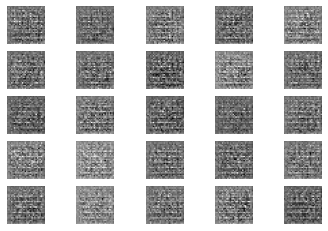

50 [D loss: 0.592387, acc.: 74.24%] [G loss: 1.153812]
100 [D loss: 0.805980, acc.: 37.50%] [G loss: 0.585899]
150 [D loss: 0.687905, acc.: 47.73%] [G loss: 0.713719]
200 [D loss: 0.702296, acc.: 34.47%] [G loss: 0.680465]
250 [D loss: 0.701875, acc.: 41.29%] [G loss: 0.679616]
300 [D loss: 0.700731, acc.: 35.23%] [G loss: 0.691421]
350 [D loss: 0.703852, acc.: 42.80%] [G loss: 0.696792]
400 [D loss: 0.696391, acc.: 45.08%] [G loss: 0.704080]
450 [D loss: 0.685505, acc.: 51.52%] [G loss: 0.715724]
500 [D loss: 0.692778, acc.: 47.35%] [G loss: 0.717528]


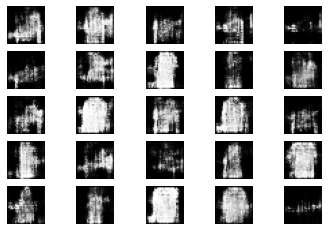

550 [D loss: 0.687241, acc.: 57.58%] [G loss: 0.729763]
600 [D loss: 0.690634, acc.: 54.55%] [G loss: 0.723446]
650 [D loss: 0.696995, acc.: 44.70%] [G loss: 0.722503]
700 [D loss: 0.695606, acc.: 51.14%] [G loss: 0.707170]
750 [D loss: 0.701012, acc.: 42.05%] [G loss: 0.708649]
800 [D loss: 0.697092, acc.: 45.83%] [G loss: 0.721868]
850 [D loss: 0.692293, acc.: 49.24%] [G loss: 0.729573]
900 [D loss: 0.697567, acc.: 42.42%] [G loss: 0.708752]
950 [D loss: 0.692586, acc.: 49.62%] [G loss: 0.710860]
1000 [D loss: 0.694101, acc.: 50.76%] [G loss: 0.710823]


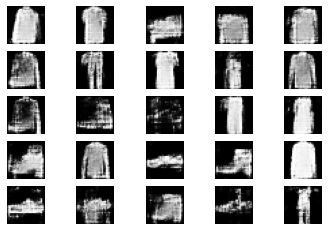

1050 [D loss: 0.695599, acc.: 50.00%] [G loss: 0.706193]
1100 [D loss: 0.695095, acc.: 47.73%] [G loss: 0.717834]
1150 [D loss: 0.694185, acc.: 50.76%] [G loss: 0.713234]
1200 [D loss: 0.692937, acc.: 49.62%] [G loss: 0.714146]
1250 [D loss: 0.691118, acc.: 53.79%] [G loss: 0.721675]
1300 [D loss: 0.692303, acc.: 57.58%] [G loss: 0.717247]
1350 [D loss: 0.702475, acc.: 44.32%] [G loss: 0.724491]
1400 [D loss: 0.692631, acc.: 48.11%] [G loss: 0.694345]
1450 [D loss: 0.691620, acc.: 51.52%] [G loss: 0.713817]
1500 [D loss: 0.693213, acc.: 50.38%] [G loss: 0.706735]


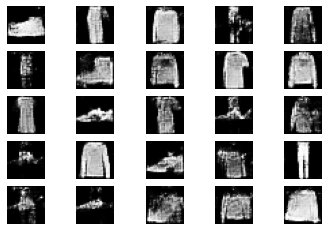

1550 [D loss: 0.692160, acc.: 47.73%] [G loss: 0.718787]
1600 [D loss: 0.688650, acc.: 57.58%] [G loss: 0.715454]
1650 [D loss: 0.697330, acc.: 47.35%] [G loss: 0.706096]
1700 [D loss: 0.690658, acc.: 56.44%] [G loss: 0.706159]
1750 [D loss: 0.691793, acc.: 54.92%] [G loss: 0.705752]
1800 [D loss: 0.692791, acc.: 54.92%] [G loss: 0.714216]
1850 [D loss: 0.694557, acc.: 45.08%] [G loss: 0.709031]
1900 [D loss: 0.692762, acc.: 51.89%] [G loss: 0.714159]
1950 [D loss: 0.691427, acc.: 55.30%] [G loss: 0.717352]
2000 [D loss: 0.689883, acc.: 58.71%] [G loss: 0.713244]


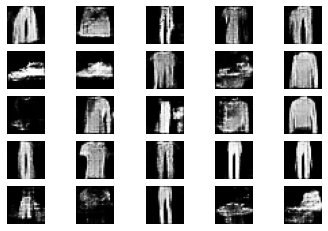

2050 [D loss: 0.689354, acc.: 57.95%] [G loss: 0.713333]
2100 [D loss: 0.691640, acc.: 51.89%] [G loss: 0.713977]
2150 [D loss: 0.689656, acc.: 55.68%] [G loss: 0.717290]
2200 [D loss: 0.693977, acc.: 51.14%] [G loss: 0.718174]
2250 [D loss: 0.702942, acc.: 44.32%] [G loss: 0.708818]
2300 [D loss: 0.690554, acc.: 54.92%] [G loss: 0.710236]
2350 [D loss: 0.692178, acc.: 49.62%] [G loss: 0.702511]
2400 [D loss: 0.690554, acc.: 52.65%] [G loss: 0.708876]
2450 [D loss: 0.694732, acc.: 43.94%] [G loss: 0.704756]
2500 [D loss: 0.691828, acc.: 53.79%] [G loss: 0.710570]


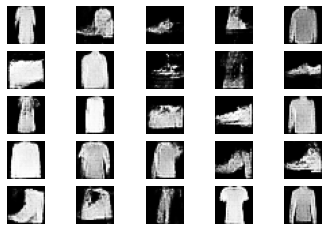

2550 [D loss: 0.694168, acc.: 48.48%] [G loss: 0.714750]
2600 [D loss: 0.695034, acc.: 47.35%] [G loss: 0.712605]
2650 [D loss: 0.693635, acc.: 53.03%] [G loss: 0.712515]
2700 [D loss: 0.693531, acc.: 47.73%] [G loss: 0.701021]
2750 [D loss: 0.690397, acc.: 55.68%] [G loss: 0.709830]
2800 [D loss: 0.695854, acc.: 49.62%] [G loss: 0.715177]
2850 [D loss: 0.692286, acc.: 53.41%] [G loss: 0.715423]
2900 [D loss: 0.693992, acc.: 53.03%] [G loss: 0.713222]
2950 [D loss: 0.692262, acc.: 54.17%] [G loss: 0.718431]
3000 [D loss: 0.692344, acc.: 51.52%] [G loss: 0.709470]


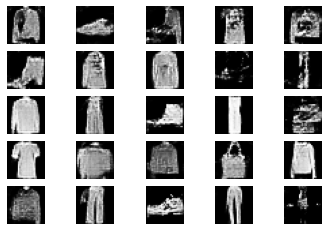

3050 [D loss: 0.687350, acc.: 62.88%] [G loss: 0.717726]
3100 [D loss: 0.695794, acc.: 47.35%] [G loss: 0.706858]
3150 [D loss: 0.697408, acc.: 45.83%] [G loss: 0.704853]
3200 [D loss: 0.691324, acc.: 54.92%] [G loss: 0.709895]
3250 [D loss: 0.687281, acc.: 56.44%] [G loss: 0.717463]
3300 [D loss: 0.692344, acc.: 50.00%] [G loss: 0.708849]
3350 [D loss: 0.693319, acc.: 49.24%] [G loss: 0.715668]
3400 [D loss: 0.695726, acc.: 52.65%] [G loss: 0.755318]
3450 [D loss: 0.693226, acc.: 51.14%] [G loss: 0.732087]
3500 [D loss: 0.692760, acc.: 48.86%] [G loss: 0.710934]


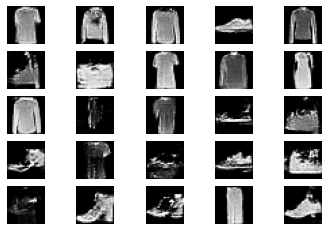

3550 [D loss: 0.694367, acc.: 47.73%] [G loss: 0.710784]
3600 [D loss: 0.688985, acc.: 58.71%] [G loss: 0.715695]
3650 [D loss: 0.692347, acc.: 50.76%] [G loss: 0.707816]
3700 [D loss: 0.691823, acc.: 52.27%] [G loss: 0.719587]
3750 [D loss: 0.686961, acc.: 56.44%] [G loss: 0.721337]
3800 [D loss: 0.691101, acc.: 51.52%] [G loss: 0.708667]
3850 [D loss: 0.690878, acc.: 54.17%] [G loss: 0.718434]
3900 [D loss: 0.692970, acc.: 51.52%] [G loss: 0.712422]
3950 [D loss: 0.690938, acc.: 52.65%] [G loss: 0.714203]
4000 [D loss: 0.694829, acc.: 50.00%] [G loss: 0.717911]


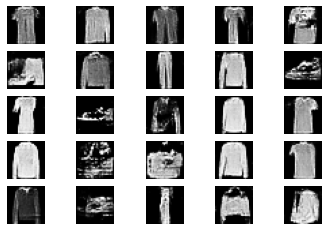

4050 [D loss: 0.694157, acc.: 46.21%] [G loss: 0.719060]
4100 [D loss: 0.692204, acc.: 53.41%] [G loss: 0.717020]
4150 [D loss: 0.691790, acc.: 53.03%] [G loss: 0.719280]
4200 [D loss: 0.694319, acc.: 44.70%] [G loss: 0.719431]
4250 [D loss: 0.698406, acc.: 48.48%] [G loss: 0.704568]
4300 [D loss: 0.682094, acc.: 59.85%] [G loss: 0.736003]
4350 [D loss: 0.695596, acc.: 50.00%] [G loss: 0.710562]
4400 [D loss: 0.689426, acc.: 52.65%] [G loss: 0.715815]
4450 [D loss: 0.691073, acc.: 55.68%] [G loss: 0.713288]
4500 [D loss: 0.686314, acc.: 54.55%] [G loss: 0.713057]


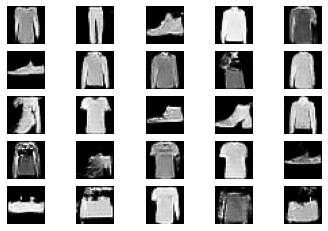

4550 [D loss: 0.687428, acc.: 56.06%] [G loss: 0.719247]
4600 [D loss: 0.689852, acc.: 50.38%] [G loss: 0.712279]
4650 [D loss: 0.695211, acc.: 47.73%] [G loss: 0.710293]
4700 [D loss: 0.689871, acc.: 55.68%] [G loss: 0.712271]
4750 [D loss: 0.693791, acc.: 52.27%] [G loss: 0.714308]
4800 [D loss: 0.690665, acc.: 55.30%] [G loss: 0.714069]
4850 [D loss: 0.692446, acc.: 53.03%] [G loss: 0.715848]
4900 [D loss: 0.691520, acc.: 55.30%] [G loss: 0.712476]
4950 [D loss: 0.692498, acc.: 52.65%] [G loss: 0.710050]
5000 [D loss: 0.693915, acc.: 48.86%] [G loss: 0.711746]


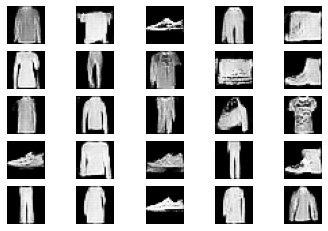

5050 [D loss: 0.690702, acc.: 54.55%] [G loss: 0.716288]
5100 [D loss: 0.693343, acc.: 48.86%] [G loss: 0.717536]
5150 [D loss: 0.690378, acc.: 52.27%] [G loss: 0.714729]
5200 [D loss: 0.689720, acc.: 55.68%] [G loss: 0.721567]
5250 [D loss: 0.683043, acc.: 65.15%] [G loss: 0.724868]
5300 [D loss: 0.693375, acc.: 53.41%] [G loss: 0.711725]
5350 [D loss: 0.693338, acc.: 48.86%] [G loss: 0.709612]
5400 [D loss: 0.687096, acc.: 57.20%] [G loss: 0.725244]
5450 [D loss: 0.684515, acc.: 62.12%] [G loss: 0.731557]
5500 [D loss: 0.691052, acc.: 52.65%] [G loss: 0.710303]


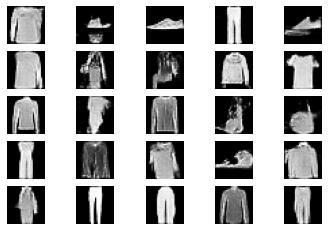

5550 [D loss: 0.697172, acc.: 45.45%] [G loss: 0.706609]
5600 [D loss: 0.691353, acc.: 52.27%] [G loss: 0.723085]
5650 [D loss: 0.688508, acc.: 54.55%] [G loss: 0.725843]
5700 [D loss: 0.691524, acc.: 53.03%] [G loss: 0.715675]
5750 [D loss: 0.689316, acc.: 51.14%] [G loss: 0.714197]
5800 [D loss: 0.687544, acc.: 59.85%] [G loss: 0.718132]
5850 [D loss: 0.691991, acc.: 50.38%] [G loss: 0.716561]
5900 [D loss: 0.690372, acc.: 53.79%] [G loss: 0.715294]
5950 [D loss: 0.694162, acc.: 49.24%] [G loss: 0.707260]
6000 [D loss: 0.696389, acc.: 48.11%] [G loss: 0.711321]


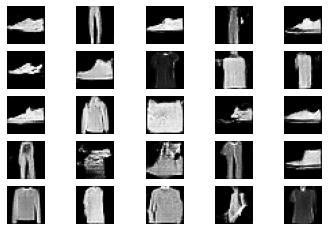

6050 [D loss: 0.693359, acc.: 49.62%] [G loss: 0.714283]
6100 [D loss: 0.692396, acc.: 49.24%] [G loss: 0.719809]
6150 [D loss: 0.690659, acc.: 53.41%] [G loss: 0.713658]
6200 [D loss: 0.692217, acc.: 49.24%] [G loss: 0.726390]
6250 [D loss: 0.687625, acc.: 57.20%] [G loss: 0.719445]
6300 [D loss: 0.690796, acc.: 57.58%] [G loss: 0.716329]
6350 [D loss: 0.690461, acc.: 55.68%] [G loss: 0.723473]
6400 [D loss: 0.694713, acc.: 48.48%] [G loss: 0.703050]
6450 [D loss: 0.691131, acc.: 51.14%] [G loss: 0.730696]
6500 [D loss: 0.696925, acc.: 45.08%] [G loss: 0.709959]


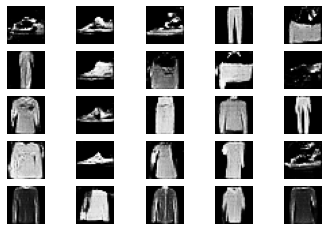

6550 [D loss: 0.691270, acc.: 52.65%] [G loss: 0.722659]
6600 [D loss: 0.692251, acc.: 51.52%] [G loss: 0.720521]
6650 [D loss: 0.690335, acc.: 51.52%] [G loss: 0.719632]
6700 [D loss: 0.696932, acc.: 50.00%] [G loss: 0.710246]
6750 [D loss: 0.692117, acc.: 48.86%] [G loss: 0.714600]
6800 [D loss: 0.694588, acc.: 47.35%] [G loss: 0.721012]
6850 [D loss: 0.695645, acc.: 46.21%] [G loss: 0.712922]
6900 [D loss: 0.693208, acc.: 51.14%] [G loss: 0.718174]
6950 [D loss: 0.692360, acc.: 53.03%] [G loss: 0.721398]
7000 [D loss: 0.691389, acc.: 53.41%] [G loss: 0.713965]


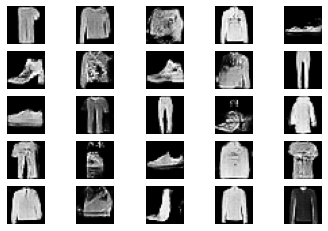

7050 [D loss: 0.686528, acc.: 59.09%] [G loss: 0.724410]
7100 [D loss: 0.697030, acc.: 44.70%] [G loss: 0.706949]
7150 [D loss: 0.690702, acc.: 52.65%] [G loss: 0.716633]
7200 [D loss: 0.691658, acc.: 48.86%] [G loss: 0.712143]
7250 [D loss: 0.688319, acc.: 53.03%] [G loss: 0.722566]
7300 [D loss: 0.690512, acc.: 57.20%] [G loss: 0.717427]
7350 [D loss: 0.693367, acc.: 49.24%] [G loss: 0.723810]
7400 [D loss: 0.687522, acc.: 56.82%] [G loss: 0.720603]
7450 [D loss: 0.683600, acc.: 59.47%] [G loss: 0.730779]
7500 [D loss: 0.691793, acc.: 54.17%] [G loss: 0.720013]


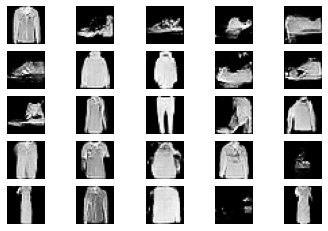

7550 [D loss: 0.692633, acc.: 52.27%] [G loss: 0.717688]
7600 [D loss: 0.700854, acc.: 44.32%] [G loss: 0.708763]
7650 [D loss: 0.694702, acc.: 49.62%] [G loss: 0.711259]
7700 [D loss: 0.693020, acc.: 52.65%] [G loss: 0.721917]
7750 [D loss: 0.691292, acc.: 51.89%] [G loss: 0.721623]
7800 [D loss: 0.690529, acc.: 51.14%] [G loss: 0.716991]
7850 [D loss: 0.691046, acc.: 53.79%] [G loss: 0.718533]
7900 [D loss: 0.694312, acc.: 50.76%] [G loss: 0.719376]
7950 [D loss: 0.692329, acc.: 51.14%] [G loss: 0.718073]
8000 [D loss: 0.686342, acc.: 54.92%] [G loss: 0.719060]


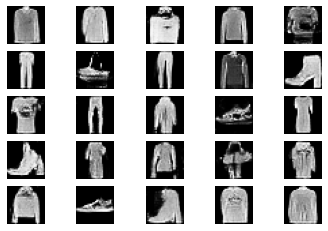

8050 [D loss: 0.689023, acc.: 56.82%] [G loss: 0.714368]
8100 [D loss: 0.689651, acc.: 52.27%] [G loss: 0.720187]
8150 [D loss: 0.689518, acc.: 54.17%] [G loss: 0.716531]
8200 [D loss: 0.692034, acc.: 52.65%] [G loss: 0.710537]
8250 [D loss: 0.689530, acc.: 55.30%] [G loss: 0.714695]
8300 [D loss: 0.693115, acc.: 48.48%] [G loss: 0.719161]
8350 [D loss: 0.692020, acc.: 52.65%] [G loss: 0.716131]
8400 [D loss: 0.689006, acc.: 54.92%] [G loss: 0.714891]
8450 [D loss: 0.688963, acc.: 51.89%] [G loss: 0.720689]
8500 [D loss: 0.692251, acc.: 52.65%] [G loss: 0.736363]


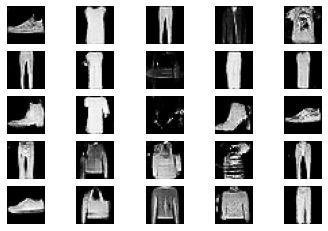

8550 [D loss: 0.687138, acc.: 56.06%] [G loss: 0.721665]
8600 [D loss: 0.685564, acc.: 57.58%] [G loss: 0.724083]
8650 [D loss: 0.694857, acc.: 49.62%] [G loss: 0.714208]
8700 [D loss: 0.690472, acc.: 51.52%] [G loss: 0.715722]
8750 [D loss: 0.691284, acc.: 50.00%] [G loss: 0.727523]
8800 [D loss: 0.693403, acc.: 50.38%] [G loss: 0.718041]
8850 [D loss: 0.695187, acc.: 48.11%] [G loss: 0.725956]
8900 [D loss: 0.692722, acc.: 54.55%] [G loss: 0.720139]
8950 [D loss: 0.690839, acc.: 51.14%] [G loss: 0.716962]
9000 [D loss: 0.694621, acc.: 48.48%] [G loss: 0.721449]


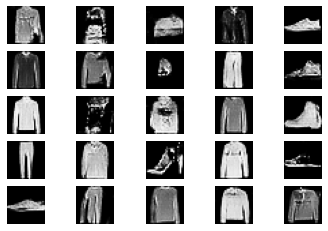

9050 [D loss: 0.689644, acc.: 56.06%] [G loss: 0.724481]
9100 [D loss: 0.690963, acc.: 56.82%] [G loss: 0.725593]
9150 [D loss: 0.696636, acc.: 47.73%] [G loss: 0.709071]
9200 [D loss: 0.695126, acc.: 47.73%] [G loss: 0.710005]
9250 [D loss: 0.691895, acc.: 52.65%] [G loss: 0.718191]
9300 [D loss: 0.684814, acc.: 58.71%] [G loss: 0.722804]
9350 [D loss: 0.693378, acc.: 49.24%] [G loss: 0.718303]
9400 [D loss: 0.687952, acc.: 56.44%] [G loss: 0.719696]
9450 [D loss: 0.693948, acc.: 52.27%] [G loss: 0.741287]
9500 [D loss: 0.687952, acc.: 57.58%] [G loss: 0.717689]


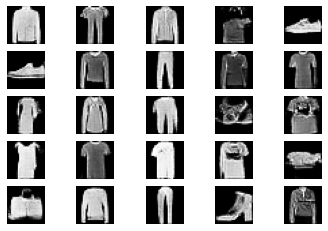

9550 [D loss: 0.689197, acc.: 55.68%] [G loss: 0.722712]
9600 [D loss: 0.691444, acc.: 53.03%] [G loss: 0.721394]
9650 [D loss: 0.694885, acc.: 47.35%] [G loss: 0.721299]
9700 [D loss: 0.695667, acc.: 41.29%] [G loss: 0.717220]
9750 [D loss: 0.690997, acc.: 51.52%] [G loss: 0.730197]
9800 [D loss: 0.684658, acc.: 58.33%] [G loss: 0.716161]
9850 [D loss: 0.687352, acc.: 56.82%] [G loss: 0.722661]
9900 [D loss: 0.694152, acc.: 49.24%] [G loss: 0.724328]
9950 [D loss: 0.690821, acc.: 53.03%] [G loss: 0.720905]


In [45]:
gan = GAN()
gan.train(epochs=10000, batch_size=132, sample_interval=500)